In [136]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import patsy as pt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA
from scipy import sparse as sp
from mpl_toolkits.mplot3d import Axes3D
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# 1. SIEM Log File - EDA

In [32]:
#1.1 - Exporting Dataset / Log File
#Last Update of Log File - 07.02.2023, 19:14

#destinationhost_CF and sourcehost_CF-> name of our VM (honeypotaitu-vm) - DROPPED
#label_CF -> country name and ip address of intruders - DROPPED

#country_CF -> country of intruders
#state_CF -> state or region of intruders
#latitude_CF -> north or south of the equator measuring (coordinates)
#longitude_CF -> east or west of the prime meridian measuring (coordinates)
#timestamp_CF -> time of connection / bruteforcing
#username_CF -> usernames that intruders used for bruteforcing

log = pd.read_csv('log.csv')
display(log)

#log.drop(['TenantId', 'SourceSystem', 'MG', 'ManagementGroupName', 'TimeGenerated', 'Computer', 'RawData', 'Type', '_ResourceId', 'destinationhost_CF', 'label_CF'], axis=1, inplace=True)
#log.to_csv('log.csv', index=False)

,timestamp_CF,country_CF,state_CF,sourcehost_CF,username_CF,longitude_CF,latitude_CF
0,2023-02-06T09:07:25Z,Belgium,Brussels,181.214.218.45,RECEPTION2,4.35609,50.84439
1,2023-02-06T09:07:23Z,India,Maharashtra,14.98.168.90,for,73.01204,19.14248
2,2023-02-06T09:07:21Z,Netherlands,North Holland,181.214.206.71,ADMINISTRATOR,4.87326,52.37018
3,2023-02-06T09:07:20Z,India,Maharashtra,14.98.168.90,for,73.01204,19.14248
4,2023-02-06T09:07:19Z,Netherlands,North Holland,181.214.206.156,MED,4.87326,52.37018
...,...,...,...,...,...,...,...
15841,2023-02-05T22:14:21Z,Kazakhstan,NaN,46.34.195.4,aituadmin,76.95694,43.25226
15842,2023-02-05T22:45:01Z,Kazakhstan,NaN,46.34.195.4,aituadmin,76.95694,43.25226
15843,2023-02-05T22:54:41Z,United States,Washington,20.231.60.181,AZUREADMIN,-122.89166,47.03956
15844,2023-02-05T23:34:11Z,Singapore,NaN,20.195.57.230,ADMINUSER,103.85211,1.29041


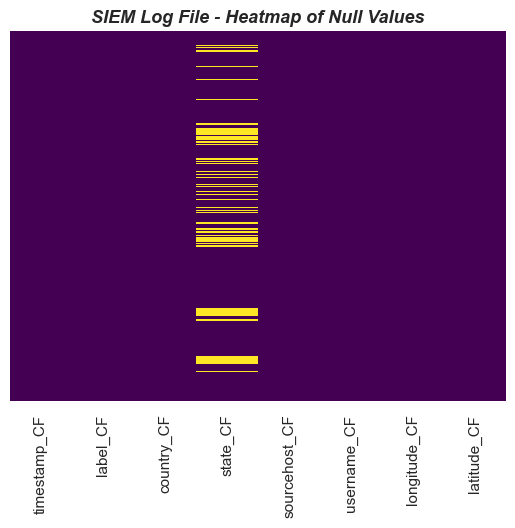

timestamp_CF        0
label_CF            0
country_CF          0
state_CF         3069
sourcehost_CF       0
username_CF         0
longitude_CF        0
latitude_CF         0
dtype: int64


In [13]:
#1.2 - Checking for null / zero values
plt.title('SIEM Log File - Heatmap of Null Values', fontsize=13, style='italic', weight='bold')
sns.heatmap(log.isnull(), yticklabels = False, cbar=False, cmap="viridis")
plt.show()

print(log.isnull().sum())

In [43]:
#1.3 - Edit data in columns

#NaN values in state_CF to "N/A" string
log['state_CF'] = log['state_CF'].fillna('N/A')

#ISO 8601 timestamp_CF to datetime format
log['timestamp_CF'] = pd.to_datetime(log['timestamp_CF'])

display(log)

,timestamp_CF,country_CF,state_CF,sourcehost_CF,username_CF,longitude_CF,latitude_CF
0,2023-02-06 09:07:25+00:00,Belgium,Brussels,181.214.218.45,RECEPTION2,4.35609,50.84439
1,2023-02-06 09:07:23+00:00,India,Maharashtra,14.98.168.90,for,73.01204,19.14248
2,2023-02-06 09:07:21+00:00,Netherlands,North Holland,181.214.206.71,ADMINISTRATOR,4.87326,52.37018
3,2023-02-06 09:07:20+00:00,India,Maharashtra,14.98.168.90,for,73.01204,19.14248
4,2023-02-06 09:07:19+00:00,Netherlands,North Holland,181.214.206.156,MED,4.87326,52.37018
...,...,...,...,...,...,...,...
15841,2023-02-05 22:14:21+00:00,Kazakhstan,N/A,46.34.195.4,aituadmin,76.95694,43.25226
15842,2023-02-05 22:45:01+00:00,Kazakhstan,N/A,46.34.195.4,aituadmin,76.95694,43.25226
15843,2023-02-05 22:54:41+00:00,United States,Washington,20.231.60.181,AZUREADMIN,-122.89166,47.03956
15844,2023-02-05 23:34:11+00:00,Singapore,N/A,20.195.57.230,ADMINUSER,103.85211,1.29041


In [69]:
#1.4 - Counting unique values
print('Count Countries:', log['country_CF'].nunique())
print(log['country_CF'].unique().tolist())

print('Count States:', log['state_CF'].nunique())
print(log['state_CF'].unique().tolist())

print('Count IPs:', log['sourcehost_CF'].nunique())
print(log['sourcehost_CF'].unique().tolist())

print('Count Bruteforcing Usernames:', log['username_CF'].nunique())
print(log['username_CF'].unique().tolist())

Count Countries: 15
['Belgium', 'India', 'Netherlands', 'Ireland', 'Cambodia', 'United States', 'Singapore', 'Philippines', 'Russia', 'Belize', 'Kazakhstan', 'Saudi Arabia', 'Ethiopia', 'United Kingdom', 'China']
Count States: 14
['Brussels', 'Maharashtra', 'North Holland', 'N/A', 'Phnom Penh', 'Washington', 'National Capital Region', 'Far Eastern Federal District', 'Karnataka', 'New York', 'Northwestern Federal District', 'England', 'New Jersey', 'Shanghai']
Count IPs: 32
['181.214.218.45', '14.98.168.90', '181.214.206.71', '181.214.206.156', '40.127.192.124', '221.120.160.130', '20.124.251.35', '52.183.58.231', '20.232.161.175', '20.195.57.230', '122.52.201.146', '203.126.28.130', '79.105.5.56', '45.227.254.49', '46.34.195.94', '93.112.215.84', '103.213.209.170', '72.43.185.108', '87.251.75.120', '185.170.144.3', '51.195.121.77', '161.35.11.215', '196.189.185.241', '196.189.185.247', '213.226.123.35', '211.253.37.225', '176.10.80.6', '103.16.61.234', '80.94.95.80', '101.34.53.120', '

In [78]:
#1.5 - Event Counts Dataset with charts (country_cf)
grouplog = pd.read_excel('export_data.xlsx')
grouplog.drop(['destinationhost_CF'], axis=1, inplace=True)
grouplog = grouplog.sort_values(by = 'event_count', ascending=False)
display(grouplog)

fig = px.bar(grouplog, x = 'event_count', y = 'country_CF', color = 'label_CF', title = 'Bar Charts - Events by countries')
fig.show()

,sourcehost_CF,latitude_CF,longitude_CF,country_CF,label_CF,event_count
0,181.214.218.45,50.84439,4.35609,Belgium,Belgium - 181.214.218.45,3009
1,181.214.206.71,52.37018,4.87326,Netherlands,Netherlands - 181.214.206.71,2488
2,181.214.206.156,52.37018,4.87326,Netherlands,Netherlands - 181.214.206.156,2350
8,14.98.168.90,19.14248,73.01204,India,India - 14.98.168.90,1083
19,72.43.185.108,40.67800,-73.82046,United States,United States - 72.43.185.108,708
...,...,...,...,...,...,...
11,20.124.251.35,47.03956,-122.89166,United States,United States - 20.124.251.35,1
27,161.35.11.215,40.67800,-73.82046,United States,United States - 161.35.11.215,1
26,51.195.121.77,40.67800,-73.82046,United States,United States - 51.195.121.77,1
16,46.34.195.94,43.25226,76.95694,Kazakhstan,Kazakhstan - 46.34.195.94,1


In [80]:
#1.6 - Event Counts Map
fig = px.scatter_mapbox(grouplog, lat='latitude_CF', lon='longitude_CF', 
                        color='event_count', size='event_count',
                        color_continuous_scale = px.colors.sequential.Plasma,
                        hover_name='country_CF', size_max=15,
                        mapbox_style="open-street-map")
fig.show()

# 2. SIEM Log File - K-Means + TfidfVectorizer (username_CF)

In [84]:
#2.1 - TfidfVectorizer
documents = log['username_CF'].values.astype("U")
vectorizer = TfidfVectorizer(stop_words='english')
features_vector = vectorizer.fit_transform(documents)

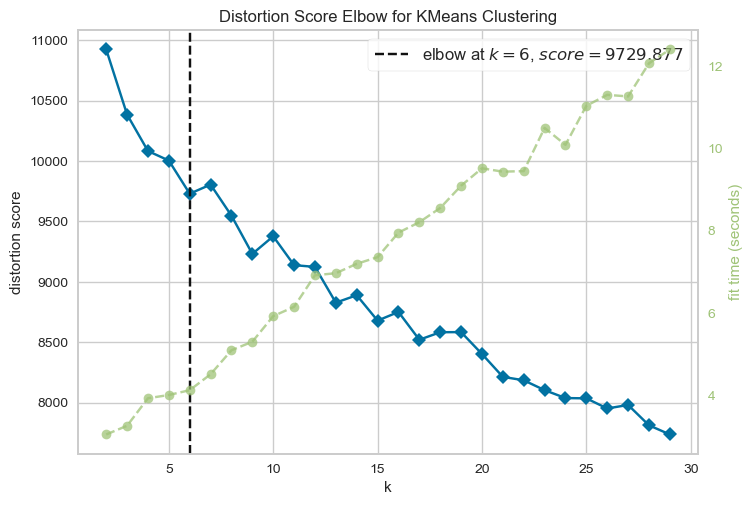

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [118]:
#2.2 - Elbow Method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(features_vector)       
visualizer.show()
plt.show()

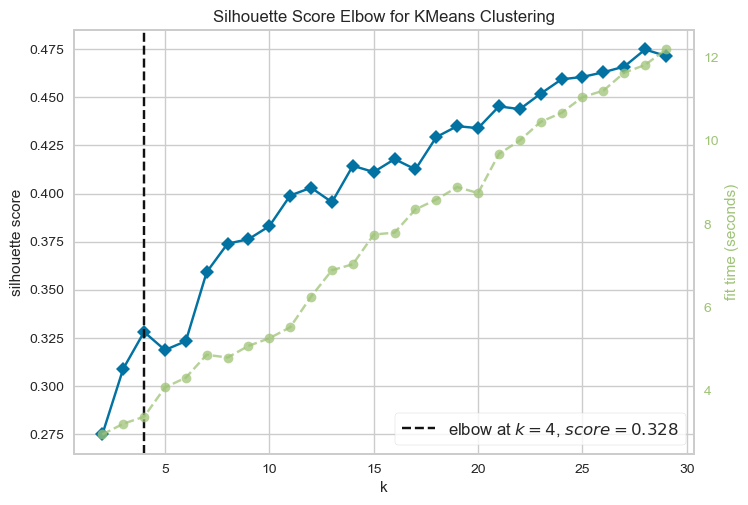

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [119]:
#2.3 - Silhouette Method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), metric='silhouette', timings= True)
visualizer.fit(features_vector)
visualizer.show()
plt.show()

In [191]:
#2.5 - K-Means (K = 2)
model = KMeans(n_clusters = 2, init = 'k-means++', random_state = 0)
model.fit(features_vector)

log['cluster'] = model.labels_
display(log.head())

,timestamp_CF,country_CF,state_CF,sourcehost_CF,username_CF,longitude_CF,latitude_CF,cluster
0,2023-02-06 09:07:25+00:00,Belgium,Brussels,181.214.218.45,RECEPTION2,4.35609,50.84439,0
1,2023-02-06 09:07:23+00:00,India,Maharashtra,14.98.168.90,for,73.01204,19.14248,0
2,2023-02-06 09:07:21+00:00,Netherlands,North Holland,181.214.206.71,ADMINISTRATOR,4.87326,52.37018,1
3,2023-02-06 09:07:20+00:00,India,Maharashtra,14.98.168.90,for,73.01204,19.14248,0
4,2023-02-06 09:07:19+00:00,Netherlands,North Holland,181.214.206.156,MED,4.87326,52.37018,0


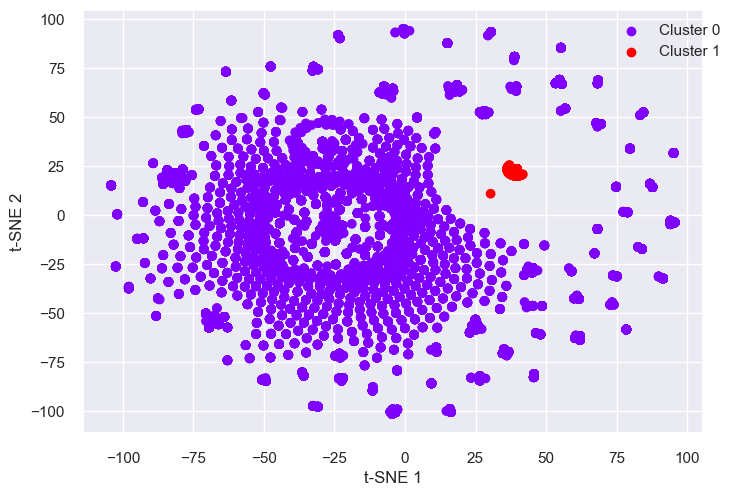

In [192]:
#2.6 - TSNE Visualization (2 Dimensional, K = 2)
tsne = TSNE(n_components = 2, perplexity=30, learning_rate=200)
features_tsne = tsne.fit_transform(features_vector.toarray())
plt.scatter(features_tsne[:,0], features_tsne[:,1], c=model.labels_, cmap='rainbow')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

#List of Cluster Labels
cluster_labels = np.unique(model.labels_)
color_codes = plt.cm.rainbow(np.linspace(0, 1, len(cluster_labels)))
cluster_strings = ['Cluster ' + str(label) for label in cluster_labels]

#Scatter Plot Legend
for label, color in zip(cluster_strings, color_codes):
    plt.scatter([], [], c = color.reshape(1, -1), label=label)
plt.legend(bbox_to_anchor = (1.05, 1))
plt.show()

In [193]:
#2.7 - TSNE Visualization (3 Dimensional, K = 2)
tsne = TSNE(n_components = 3, perplexity = 30, learning_rate = 200)
features_tsne = tsne.fit_transform(features_vector.toarray())

fig = px.scatter_3d(x = features_tsne[:,0], y = features_tsne[:,1], z = features_tsne[:,2], color = model.labels_)
fig.show()

In [196]:
#2.8 - Clusters Centroids + Feature Terms of Each Clusters (K = 2)
print("Cluster centroids: \n")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(2):
    print("Cluster %d:" % i)
    for j in order_centroids[i, :40]:
        print (' %s' % terms[j])
    print('------------')

Cluster centroids: 

Cluster 0:
 admin
 user
 accounts
 vm
 honeypotaitu
 hp
 azureadmin
 subbareddy
 divya
 j200_series
 sharad
 nagaraj
 adminuser
 admins
 defaultuser0
 azureuser
 joe
 testuser
 kevin
 vmware
 developer
 admin2023
 vmazure
 demo
 spadmin
 demouser
 adrian
 webuser
 xerox
 support
 localadmin
 adadmin
 maini_cis
 domain
 stadmin
 admin0302
 admin01
 vecta
 vmadmin
 pacific
------------
Cluster 1:
 administrator
 їёбё
 frey
 freeman
 freedom
 fred
 frank
 francois
 francesca
 frances
 fran
 fperry
 fperez
 forval
 formazione
 formation
 foreman
 foodservice
 foglight
 focus
 fmurphy
 frios
 frogers
 frontdesk
 fwilliams
 gary
 gareth
 gar
 gail
 gaia
 gael
 gadmin
 fwood
 fvang
 frontdesk1
 fusionadmin
 furniture
 fuad
 ftpuser1
 ftpuser
------------
